In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns

# Distribution of No of Employees

In [112]:
num_employees = pd.read_excel("../data/Financial/number of employees.xls", sheet_name = "Results")

WARNING *** file size (4723798) not 512 + multiple of sector size (512)


## There is a significant peak at 500 !! How to interpret it. Is RDD valid anymore

Text(0,0.5,'No. of Companies')

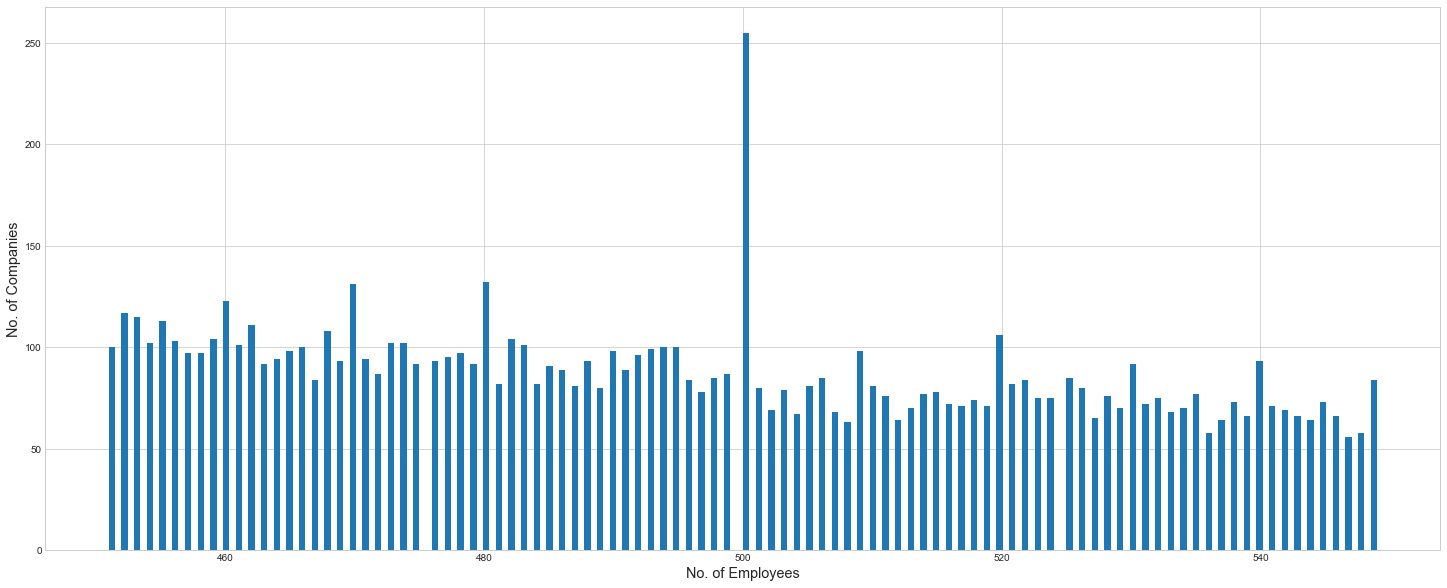

In [113]:
cond1 = (num_employees["Number of employees\nLast avail. yr"] == "n.a.")
cond2 = (num_employees["Number of employees\nLast avail. yr"] == "Credit needed")
cond3 = (num_employees["Number of employees\nLast avail. yr"]>450)
cond4 = (num_employees["Number of employees\nLast avail. yr"]<550)
cond5 = num_employees["Number of employees\nLast avail. yr"].isna()

num_employees = num_employees.loc[~cond1 & ~cond2]
num_employees["Number of employees\nLast avail. yr"] = num_employees["Number of employees\nLast avail. yr"].astype(int)
num_employees = num_employees.loc[cond3 & cond4]

num_employees["Number of employees\nLast avail. yr"].hist(bins=200, figsize = (25,10))
plt.xlabel("No. of Employees", size  = "x-large")
plt.ylabel("No. of Companies", size  = "x-large")

# Analysis of other Financial Variables

In [114]:
treatment_group = pd.read_excel("../data/Financial/treatment_group.xls", sheet_name = "Results")
control_group = pd.read_excel("../data/Financial/control_group.xls", sheet_name = "Results")

WARNING *** file size (2800805) not 512 + multiple of sector size (512)
WARNING *** file size (8274522) not 512 + multiple of sector size (512)


In [115]:
rnd_expenses_cols = [c for c in treatment_group.columns if "Research & Development expenses\nth EUR\n" in c and "Last" not in c]
rnd_expenses_by_or_cols = [c for c in treatment_group.columns if "R&D expenses / Operating revenue\n%\n" in c and "Last" not in c]
or_per_emp_cols = [c for c in treatment_group.columns if "Operating revenue per employee\nth EUR\n" in c and "Last" not in c]
pmargin_cols = [c for c in treatment_group.columns if "Profit margin\n%\n" in c and "Last" not in c]
category_cols = ["Total assets\nth EUR\nLast avail. yr","Country","Industry text"]

In [116]:
def prepare_dataset(columns, post_year = 2017, control_for = [], begin_year=2014):
    use_columns = columns + control_for
    tr = treatment_group[use_columns].fillna(0)
    cn = control_group[use_columns].fillna(0)
    
    tr.columns = [c[-4:] if c not in control_for else c for c in tr.columns]
    cn.columns = [c[-4:] if c not in control_for else c for c in cn.columns]
    
    value_columns = [c for c in tr.columns if c not in control_for]
    tr_panel = pd.melt(tr, id_vars = control_for, value_vars=value_columns, var_name ="year", value_name = "Y")
    cn_panel = pd.melt(cn, id_vars = control_for, value_vars=value_columns, var_name ="year", value_name = "Y")
    
    tr_panel["treated"] = 1
    cn_panel["treated"] = 0
    
    panel = pd.concat([tr_panel,cn_panel]).reset_index(drop = True)
    panel["year"] = panel["year"].astype(int)
    
    panel = panel.loc[panel.year >=begin_year].reset_index(drop=True)
    
    panel.loc[panel.year >= post_year,"post"] = 1
    panel.loc[panel.year < post_year,"post"] = 0
    
    panel = panel.loc[((panel.Y != "n.a.") & (panel.Y != "n.s."))]
#     panel.loc[panel.Y == "n.a.","Y"] = 0
#     panel.loc[panel.Y == "n.s.","Y"] = 0
    panel.Y = panel.Y.astype(float)
    
    panel["post_treated"] = panel["post"]*panel["treated"]
    panel["intercept"] = 1
    return panel[["post","treated","post_treated","intercept", "Y", "year"] + control_for]

In [117]:
def parallel_trend_assumption(panel):
    def plot_trend(pre_panel, post_panel,c = "red", annotation=""):
        m_pre = sm.OLS(pre_panel[["Y"]], pre_panel[["year","intercept"]]).fit()
        m_post = sm.OLS(post_panel[["Y"]], post_panel[["year", "intercept"]]).fit()
        
        x_pre_values = sorted(pre_panel["year"].unique())
        x_pre_values += [max(x_pre_values)+1]
        y_pre_values = [m_pre.params["intercept"] +(m_pre.params["year"]*x) for x in x_pre_values]
        
        x_post_values = sorted(post_panel["year"].unique())
        y_post_values = [m_post.params["intercept"] +(m_post.params["year"]*x) for x in x_post_values]
        
        plt.plot(x_pre_values+x_post_values, y_pre_values+y_post_values, c=c, label = annotation)
                
    pre_treatment = panel.loc[(panel.treated ==1) & (panel.post==0)].reset_index(drop=True)
    post_treatment = panel.loc[(panel.treated ==1) & (panel.post==1)].reset_index(drop=True)
    
    pre_control = panel.loc[(panel.treated ==0) & (panel.post==0)].reset_index(drop=True)
    post_control = panel.loc[(panel.treated ==0) & (panel.post==1)].reset_index(drop=True)
    
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(25,8))
    plt.axvline(post_treatment["year"].min(), ls = "-.", c="crimson")
    
    plot_trend(pre_treatment,post_treatment, c = "navy", annotation = "Treatment Group")
    plot_trend(pre_control, post_control, c="green", annotation = "Control Group")
    plt.legend(loc=2, prop={'size': 15})
    plt.xlabel("Year", size  = "x-large")
    plt.ylabel("Outcome", size  = "x-large")


# Regression using R&D Spending

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     45.41
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.53e-29
Time:                        23:28:46   Log-Likelihood:                -80973.
No. Observations:                5559   AIC:                         1.620e+05
Df Residuals:                    5555   BIC:                         1.620e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     2663.4355   1.29e+04      0.206      0.837   -2.26e+04     2.8e+04
treated       1.608e+05    1.8e+04      8.954      0.000    1.26e+05    1.96e+05
post           795.7689      2e+04      0.040      0.968   -3.84e+04       4e+04
post_treated  -533.9673   2.79e+04     -0.019      0.985   -5.53e+04    5.42e+04
==============================================================================
Omnibus:                     9319.133   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6187123.641
Skew:                          11.489   Prob(JB):                         0.00
Kurtosis:                     164.814   Cond. No.                         6.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

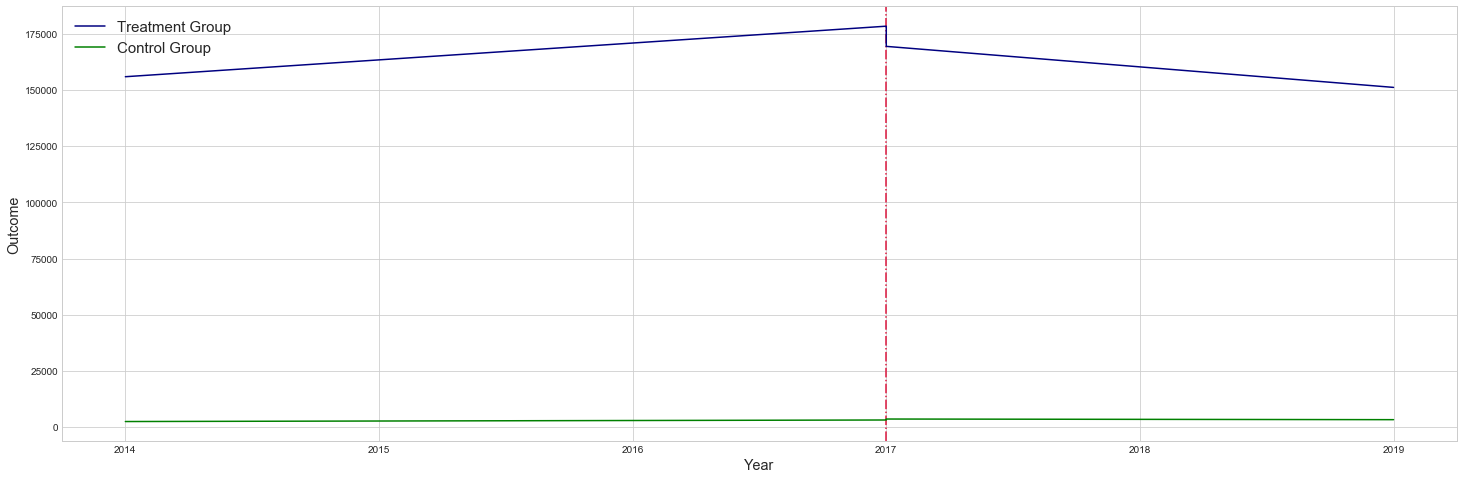

In [118]:
control_for = []

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
parallel_trend_assumption(panel)
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

# Regression using R&D Spending (Controlled for Country  & Total Assets)

In [119]:
control_for = ["Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     30.50
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           7.18e-74
Time:                        23:28:47   Log-Likelihood:                -80848.
No. Observations:                5559   AIC:                         1.617e+05
Df Residuals:                    5545   BIC:                         1.618e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept         -7.081e+04   9.77e+04     -0.725      0.469   -2.62e+05    1.21e+05
treated            1.127e+05   1.81e+04      6.225      0.000    7.72e+04    1.48e+05
post               8545.2341   1.96e+04      0.436      0.663   -2.99e+04    4.69e+04
post_treated        1.45e+04   2.74e+04      0.529      0.597   -3.92e+04    6.82e+04
d__Belgium         6.992e+04   1.08e+05      0.648      0.517   -1.42e+05    2.81e+05
d__Denmark         1.691e+05   1.09e+05      1.556      0.120   -4.39e+04    3.82e+05
d__France          5.719e+04   9.72e+04      0.588      0.556   -1.33e+05    2.48e+05
d__Germany         3.857e+05   9.99e+04      3.861      0.000     1.9e+05    5.81e+05
d__Ireland         1784.4268   1.34e+05      0.013      0.989   -2.61e+05    2.65e+05
d__Luxembourg      2.412e+04   1.62e+05      0.149      0.881   -2.93e+05    3.41e+05
d__Sweden          1.134e+05      1e+05      1.129      0.259   -8.35e+04     3.1e+05
d__Switzerland     3.918e+05   1.02e+05      3.843      0.000    1.92e+05    5.92e+05
d__Turkey         -2.495e+04   1.03e+05     -0.241      0.809   -2.28e+05    1.78e+05
d__United Kingdom  3.485e+04   9.77e+04      0.357      0.721   -1.57e+05    2.26e+05
==============================================================================
Omnibus:                     9138.949   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5682834.510
Skew:                          11.043   Prob(JB):                         0.00
Kurtosis:                     158.071   Cond. No.                         66.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     537.7
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:48   Log-Likelihood:                -80130.
No. Observations:                5559   AIC:                         1.603e+05
Df Residuals:                    5554   BIC:                         1.603e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                           1224.3435   1.11e+04      0.110      0.912   -2.05e+04     2.3e+04
treated                             2.939e+04   1.57e+04      1.870      0.062   -1424.893    6.02e+04
post                                 788.1515   1.72e+04      0.046      0.963   -3.29e+04    3.45e+04
post_treated                       -2891.3056    2.4e+04     -0.120      0.904      -5e+04    4.42e+04
Total assets
th EUR
Last avail. yr     0.0121      0.000     44.344      0.000       0.012       0.013
==============================================================================
Omnibus:                     8546.764   Durbin-Watson:                   2.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6415292.765
Skew:                           9.459   Prob(JB):                         0.00
Kurtosis:                     168.345   Cond. No.                     1.18e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [121]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     179.3
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:48   Log-Likelihood:                -80002.
No. Observations:                5559   AIC:                         1.600e+05
Df Residuals:                    5544   BIC:                         1.601e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -5.396e+04   8.39e+04     -0.643      0.520   -2.18e+05    1.11e+05
treated                            -1.713e+04   1.58e+04     -1.083      0.279   -4.81e+04    1.39e+04
post                                7359.2489   1.68e+04      0.437      0.662   -2.56e+04    4.03e+04
post_treated                        1.196e+04   2.35e+04      0.508      0.611   -3.42e+04    5.81e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     44.416      0.000       0.011       0.013
d__Belgium                          1.137e+05   9.27e+04      1.227      0.220    -6.8e+04    2.95e+05
d__Denmark                          2.103e+05   9.33e+04      2.253      0.024    2.73e+04    3.93e+05
d__France                           2.637e+04   8.35e+04      0.316      0.752   -1.37e+05     1.9e+05
d__Germany                          3.005e+05   8.58e+04      3.501      0.000    1.32e+05    4.69e+05
d__Ireland                           4.27e+04   1.15e+05      0.370      0.711   -1.83e+05    2.69e+05
d__Luxembourg                       1.206e+05   1.39e+05      0.869      0.385   -1.52e+05    3.93e+05
d__Sweden                           1.211e+05   8.63e+04      1.404      0.160    -4.8e+04     2.9e+05
d__Switzerland                       3.62e+05   8.76e+04      4.134      0.000     1.9e+05    5.34e+05
d__Turkey                           4.803e+04   8.88e+04      0.541      0.589   -1.26e+05    2.22e+05
d__United Kingdom                   3.477e+04   8.39e+04      0.414      0.679    -1.3e+05    1.99e+05
==============================================================================
Omnibus:                     8435.041   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6007153.334
Skew:                           9.222   Prob(JB):                         0.00
Kurtosis:                     162.983   Cond. No.                     1.11e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression using R&D Spending/Operating Revenue

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     71.72
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.97e-45
Time:                        23:28:49   Log-Likelihood:                -19915.
No. Observations:                5138   AIC:                         3.984e+04
Df Residuals:                    5134   BIC:                         3.987e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        8.0619      0.319     25.265      0.000       7.436       8.687
treated         -4.9974      0.428    -11.689      0.000      -5.836      -4.159
post            -0.6059      0.496     -1.222      0.222      -1.578       0.366
post_treated     0.4979      0.666      0.748      0.455      -0.808       1.803
==============================================================================
Omnibus:                     4291.467   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110328.339
Skew:                           3.967   Prob(JB):                         0.00
Kurtosis:                      24.270   Cond. No.                         6.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

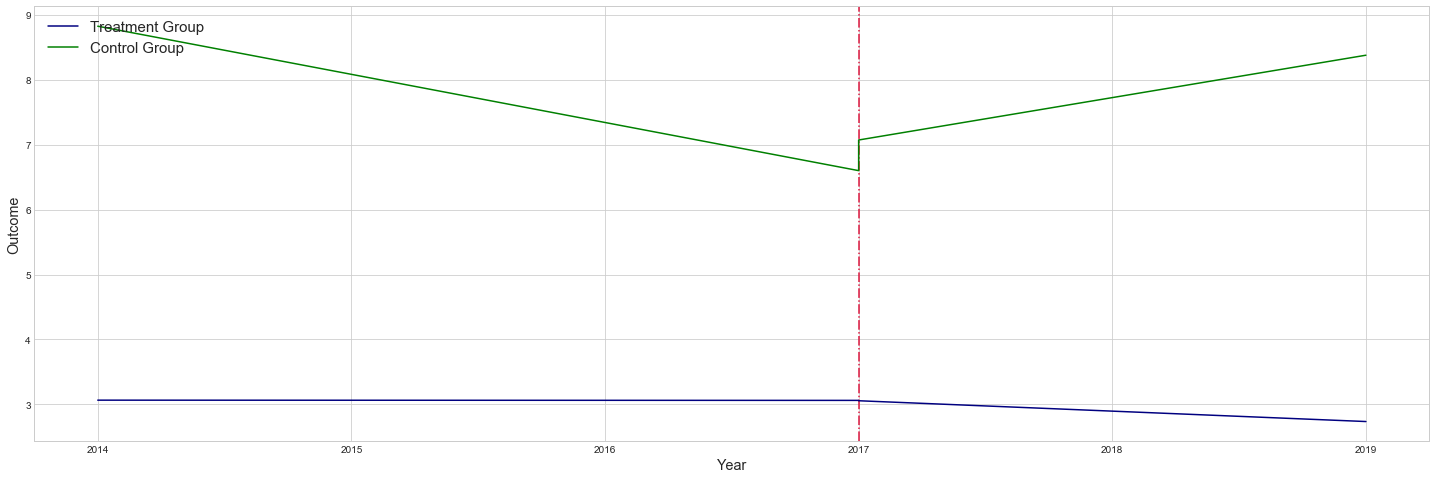

In [122]:
control_for = []

panel = prepare_dataset(rnd_expenses_by_or_cols, post_year = 2017, control_for = control_for )
parallel_trend_assumption(panel)
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

# Regression using R&D Spending/Operating Revenue (Controlled for Country  & Total Assets)

In [123]:
control_for = ["Country"]

panel = prepare_dataset(rnd_expenses_by_or_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     72.41
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          1.57e-176
Time:                        23:28:49   Log-Likelihood:                -19588.
No. Observations:                5138   AIC:                         3.920e+04
Df Residuals:                    5124   BIC:                         3.929e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            14.4513      2.137      6.761      0.000      10.261      18.642
treated              -6.0573      0.415    -14.608      0.000      -6.870      -5.244
post                 -0.6652      0.466     -1.428      0.153      -1.579       0.248
post_treated          0.7857      0.627      1.254      0.210      -0.443       2.014
d__Belgium            0.0697      2.384      0.029      0.977      -4.604       4.744
d__Denmark            6.5472      2.389      2.740      0.006       1.863      11.232
d__France            -9.1932      2.125     -4.327      0.000     -13.359      -5.028
d__Germany           -1.6776      2.189     -0.767      0.443      -5.968       2.613
d__Ireland           -7.9903      2.933     -2.725      0.006     -13.740      -2.241
d__Luxembourg        -3.7586      3.532     -1.064      0.287     -10.682       3.165
d__Sweden             2.3431      2.210      1.060      0.289      -1.990       6.677
d__Switzerland       -2.9644      2.234     -1.327      0.185      -7.344       1.415
d__Turkey            -8.7905      2.259     -3.891      0.000     -13.220      -4.361
d__United Kingdom    -3.3857      2.137     -1.584      0.113      -7.576       0.804
==============================================================================
Omnibus:                     4391.868   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131358.651
Skew:                           4.046   Prob(JB):                         0.00
Kurtosis:                      26.412   Cond. No.                         65.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(rnd_expenses_by_or_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     53.81
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.70e-44
Time:                        23:28:50   Log-Likelihood:                -19915.
No. Observations:                5138   AIC:                         3.984e+04
Df Residuals:                    5133   BIC:                         3.987e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                              8.0622      0.319     25.264      0.000       7.437       8.688
treated                               -4.9690      0.435    -11.431      0.000      -5.821      -4.117
post                                  -0.6059      0.496     -1.222      0.222      -1.578       0.366
post_treated                           0.4983      0.666      0.748      0.454      -0.807       1.804
Total assets
th EUR
Last avail. yr -2.623e-09   7.26e-09     -0.361      0.718   -1.69e-08    1.16e-08
==============================================================================
Omnibus:                     4291.396   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110324.175
Skew:                           3.967   Prob(JB):                         0.00
Kurtosis:                      24.269   Cond. No.                     1.26e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     179.3
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:51   Log-Likelihood:                -80002.
No. Observations:                5559   AIC:                         1.600e+05
Df Residuals:                    5544   BIC:                         1.601e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -5.396e+04   8.39e+04     -0.643      0.520   -2.18e+05    1.11e+05
treated                            -1.713e+04   1.58e+04     -1.083      0.279   -4.81e+04    1.39e+04
post                                7359.2489   1.68e+04      0.437      0.662   -2.56e+04    4.03e+04
post_treated                        1.196e+04   2.35e+04      0.508      0.611   -3.42e+04    5.81e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     44.416      0.000       0.011       0.013
d__Belgium                          1.137e+05   9.27e+04      1.227      0.220    -6.8e+04    2.95e+05
d__Denmark                          2.103e+05   9.33e+04      2.253      0.024    2.73e+04    3.93e+05
d__France                           2.637e+04   8.35e+04      0.316      0.752   -1.37e+05     1.9e+05
d__Germany                          3.005e+05   8.58e+04      3.501      0.000    1.32e+05    4.69e+05
d__Ireland                           4.27e+04   1.15e+05      0.370      0.711   -1.83e+05    2.69e+05
d__Luxembourg                       1.206e+05   1.39e+05      0.869      0.385   -1.52e+05    3.93e+05
d__Sweden                           1.211e+05   8.63e+04      1.404      0.160    -4.8e+04     2.9e+05
d__Switzerland                       3.62e+05   8.76e+04      4.134      0.000     1.9e+05    5.34e+05
d__Turkey                           4.803e+04   8.88e+04      0.541      0.589   -1.26e+05    2.22e+05
d__United Kingdom                   3.477e+04   8.39e+04      0.414      0.679    -1.3e+05    1.99e+05
==============================================================================
Omnibus:                     8435.041   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6007153.334
Skew:                           9.222   Prob(JB):                         0.00
Kurtosis:                     162.983   Cond. No.                     1.11e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression using Operating Revenue per Employee 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     27.12
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.65e-17
Time:                        23:28:51   Log-Likelihood:            -3.3878e+05
No. Observations:               37282   AIC:                         6.776e+05
Df Residuals:                   37278   BIC:                         6.776e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      435.5064     16.855     25.839      0.000     402.471     468.542
treated       -152.4612     31.116     -4.900      0.000    -213.449     -91.473
post           108.0983     27.271      3.964      0.000      54.646     161.550
post_treated  -112.7038     49.355     -2.284      0.022    -209.442     -15.966
==============================================================================
Omnibus:                    81915.411   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        493207918.229
Skew:                          20.250   Prob(JB):                         0.00
Kurtosis:                     565.013   Cond. No.                         5.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

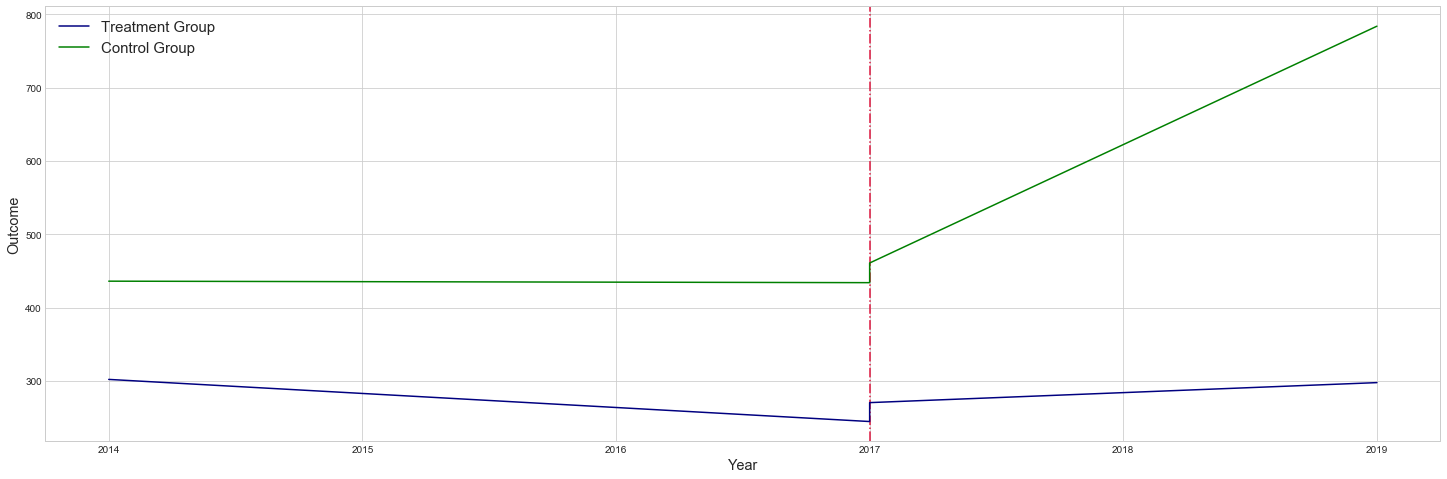

In [126]:
control_for = []

panel = prepare_dataset(or_per_emp_cols, post_year = 2017, control_for = control_for )
parallel_trend_assumption(panel)
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

# Regression using Operating Revenue per Employee (Controlled for Country  & Total Assets)

In [127]:
control_for = ["Country"]

panel = prepare_dataset(or_per_emp_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     47.16
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:52   Log-Likelihood:            -3.3785e+05
No. Observations:               37282   AIC:                         6.758e+05
Df Residuals:                   37239   BIC:                         6.762e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                   624.4428    148.938      4.193      0.000     332.520     916.365
treated                    -425.7267     32.774    -12.990      0.000    -489.964    -361.490
post                         61.8448     26.901      2.299      0.022       9.118     114.572
post_treated                -67.5366     48.308     -1.398      0.162    -162.221      27.148
d__Belgium                  874.6367    178.015      4.913      0.000     525.722    1223.552
d__Bosnia and Herzegovina  -569.7555    157.947     -3.607      0.000    -879.336    -260.175
d__Bulgaria                -484.1251    161.423     -2.999      0.003    -800.519    -167.731
d__Croatia                 -305.6029    170.185     -1.796      0.073    -639.170      27.964
d__Cyprus                   500.2788    263.495      1.899      0.058     -16.178    1016.736
d__Czech Republic           -25.9144    527.461     -0.049      0.961   -1059.752    1007.924
d__Denmark                  259.9292    177.228      1.467      0.142     -87.442     607.301
d__Estonia                 -219.9718    501.337     -0.439      0.661   -1202.606     762.663
d__Finland                  -36.5634    167.950     -0.218      0.828    -365.750     292.623
d__France                   -21.3406    153.017     -0.139      0.889    -321.258     278.577
d__Germany                  376.9464    154.020      2.447      0.014      75.064     678.829
d__Gibraltar                137.7737    945.139      0.146      0.884   -1714.725    1990.272
d__Greece                   -61.8403    175.007     -0.353      0.724    -404.859     281.178
d__Hungary                 -180.5343    257.351     -0.702      0.483    -684.949     323.880
d__Iceland                 1928.3514    299.668      6.435      0.000    1340.995    2515.708
d__Ireland                  173.1678    203.084      0.853      0.394    -224.883     571.218
d__Italy                    191.4413    160.466      1.193      0.233    -123.076     505.959
d__Latvia                  -410.5335    258.396     -1.589      0.112    -916.998      95.931
d__Lithuania               2914.2861    229.605     12.693      0.000    2464.255    3364.318
d__Luxembourg               792.0968    361.477      2.191      0.028      83.593    1500.601
d__Malta                   -513.5329   2092.828     -0.245      0.806   -4615.535    3588.469
d__Montenegro              -558.7609    171.767     -3.253      0.001    -895.429    -222.093
d__Netherlands              421.4150    185.074      2.277      0.023      58.665     784.164
d__North Macedonia         -570.9557    161.167     -3.543      0.000    -886.847    -255.064
d__Norway                   253.1908    235.635      1.075      0.283    -208.660     715.042
d__Poland                  -304.6343    154.693     -1.969      0.049    -6

In [128]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(or_per_emp_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     34.72
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.51e-29
Time:                        23:28:53   Log-Likelihood:            -3.3875e+05
No. Observations:               37282   AIC:                         6.775e+05
Df Residuals:                   37277   BIC:                         6.776e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                            434.8210     16.842     25.818      0.000     401.810     467.832
treated                             -182.6870     31.347     -5.828      0.000    -244.128    -121.246
post                                 107.9960     27.250      3.963      0.000      54.584     161.408
post_treated                        -113.6536     49.318     -2.305      0.021    -210.318     -16.989
Total assets
th EUR
Last avail. yr  4.967e-06   6.55e-07      7.578      0.000    3.68e-06    6.25e-06
==============================================================================
Omnibus:                    81965.640   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        495778707.592
Skew:                          20.279   Prob(JB):                         0.00
Kurtosis:                     566.479   Cond. No.                     8.87e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     179.3
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:53   Log-Likelihood:                -80002.
No. Observations:                5559   AIC:                         1.600e+05
Df Residuals:                    5544   BIC:                         1.601e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -5.396e+04   8.39e+04     -0.643      0.520   -2.18e+05    1.11e+05
treated                            -1.713e+04   1.58e+04     -1.083      0.279   -4.81e+04    1.39e+04
post                                7359.2489   1.68e+04      0.437      0.662   -2.56e+04    4.03e+04
post_treated                        1.196e+04   2.35e+04      0.508      0.611   -3.42e+04    5.81e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     44.416      0.000       0.011       0.013
d__Belgium                          1.137e+05   9.27e+04      1.227      0.220    -6.8e+04    2.95e+05
d__Denmark                          2.103e+05   9.33e+04      2.253      0.024    2.73e+04    3.93e+05
d__France                           2.637e+04   8.35e+04      0.316      0.752   -1.37e+05     1.9e+05
d__Germany                          3.005e+05   8.58e+04      3.501      0.000    1.32e+05    4.69e+05
d__Ireland                           4.27e+04   1.15e+05      0.370      0.711   -1.83e+05    2.69e+05
d__Luxembourg                       1.206e+05   1.39e+05      0.869      0.385   -1.52e+05    3.93e+05
d__Sweden                           1.211e+05   8.63e+04      1.404      0.160    -4.8e+04     2.9e+05
d__Switzerland                       3.62e+05   8.76e+04      4.134      0.000     1.9e+05    5.34e+05
d__Turkey                           4.803e+04   8.88e+04      0.541      0.589   -1.26e+05    2.22e+05
d__United Kingdom                   3.477e+04   8.39e+04      0.414      0.679    -1.3e+05    1.99e+05
==============================================================================
Omnibus:                     8435.041   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6007153.334
Skew:                           9.222   Prob(JB):                         0.00
Kurtosis:                     162.983   Cond. No.                     1.11e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression using Profit Margin

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     46.66
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           4.39e-30
Time:                        23:28:54   Log-Likelihood:            -1.6700e+05
No. Observations:               35253   AIC:                         3.340e+05
Df Residuals:                   35249   BIC:                         3.340e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        2.8210      0.232     12.158      0.000       2.366       3.276
treated          3.6490      0.398      9.158      0.000       2.868       4.430
post             1.6873      0.375      4.505      0.000       0.953       2.421
post_treated    -0.8566      0.631     -1.358      0.174      -2.093       0.380
==============================================================================
Omnibus:                     2664.518   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15304.846
Skew:                          -0.009   Prob(JB):                         0.00
Kurtosis:                       6.228   Cond. No.                         5.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

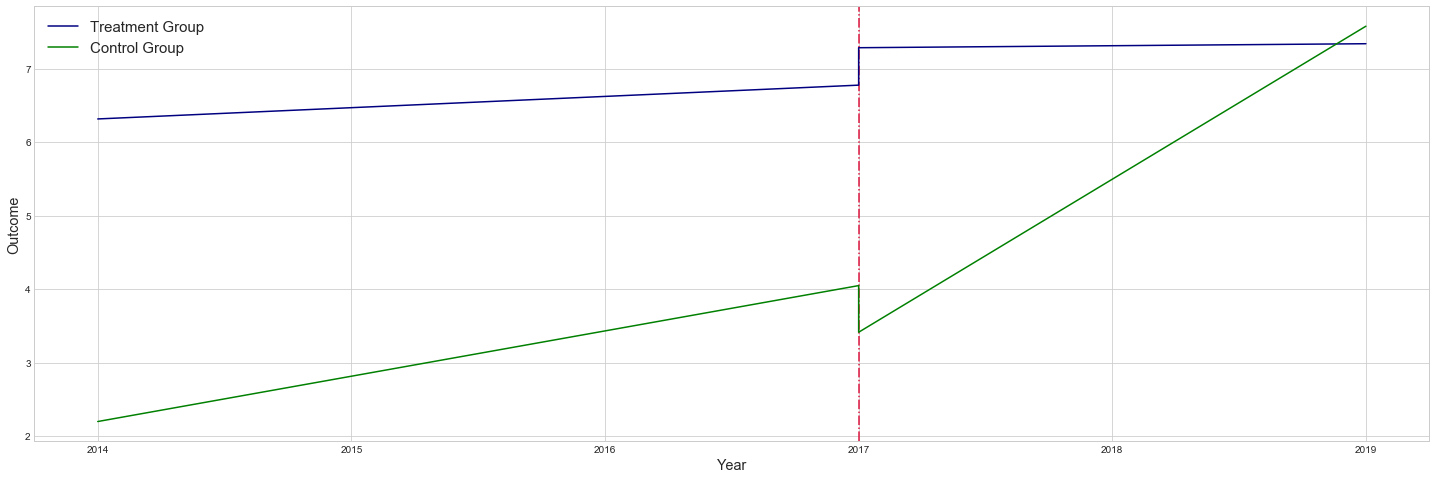

In [130]:
control_for = []

panel = prepare_dataset(pmargin_cols, post_year = 2017, control_for = control_for )
parallel_trend_assumption(panel)
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

# Regression using Profit Margin (Controlled for Country & Total Assets)

In [131]:
control_for = ["Country"]

panel = prepare_dataset(pmargin_cols, post_year = 2017, control_for = control_for )
panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= control_for, drop_first=True)
model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     55.28
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:54   Log-Likelihood:            -1.6595e+05
No. Observations:               35253   AIC:                         3.320e+05
Df Residuals:                   35210   BIC:                         3.323e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     7.1577      1.875      3.818      0.000       3.483      10.832
treated                      -0.1923      0.418     -0.460      0.645      -1.011       0.627
post                          0.9999      0.366      2.732      0.006       0.282       1.717
post_treated                 -0.4406      0.614     -0.718      0.473      -1.643       0.762
d__Belgium                    7.0220      2.211      3.176      0.001       2.688      11.356
d__Bosnia and Herzegovina   -11.6207      2.011     -5.779      0.000     -15.562      -7.679
d__Bulgaria                  -1.6648      2.119     -0.786      0.432      -5.819       2.489
d__Croatia                   -6.0086      2.172     -2.767      0.006     -10.265      -1.752
d__Cyprus                    -7.0810      3.582     -1.977      0.048     -14.102      -0.060
d__Czech Republic             5.3656      5.778      0.929      0.353      -5.960      16.691
d__Denmark                    0.4152      2.257      0.184      0.854      -4.008       4.838
d__Estonia                   11.7061      4.842      2.418      0.016       2.216      21.197
d__Finland                   -1.8970      2.135     -0.889      0.374      -6.081       2.287
d__France                    -4.8279      1.926     -2.507      0.012      -8.602      -1.054
d__Germany                    0.0825      1.944      0.042      0.966      -3.728       3.893
d__Gibraltar                  4.1928     12.134      0.346      0.730     -19.591      27.976
d__Greece                    -8.3847      2.123     -3.949      0.000     -12.546      -4.223
d__Hungary                   -0.0838      3.367     -0.025      0.980      -6.683       6.516
d__Iceland                    9.2456      3.807      2.429      0.015       1.784      16.707
d__Ireland                   -2.9377      2.674     -1.099      0.272      -8.179       2.304
d__Italy                     -4.5257      2.031     -2.228      0.026      -8.507      -0.545
d__Latvia                   -10.3837      3.320     -3.127      0.002     -16.891      -3.876
d__Lithuania                  4.8073      2.943      1.634      0.102      -0.961      10.575
d__Luxembourg                 3.2655      3.926      0.832      0.405      -4.429      10.960
d__Malta                     35.7266      5.319      6.717      0.000      25.302      46.151
d__Montenegro               -13.9138      2.218     -6.273      0.000     -18.261      -9.566
d__Netherlands                3.5257      2.333      1.511      0.131      -1.048       8.099
d__North Macedonia           -6.0337      2.038     -2.961      0.003     -10.028      -2.039
d__Norway                    -3.1792      2.188     -1.453      0.146      -7.467       1.109
d__Poland                    -4.8444      1.931     -2.508      0.012      

In [132]:
control_for = ["Total assets\nth EUR\nLast avail. yr"]

panel = prepare_dataset(pmargin_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     39.55
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           4.22e-33
Time:                        23:28:55   Log-Likelihood:            -1.6699e+05
No. Observations:               35253   AIC:                         3.340e+05
Df Residuals:                   35248   BIC:                         3.340e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                              2.8166      0.232     12.141      0.000       2.362       3.271
treated                                3.4399      0.401      8.570      0.000       2.653       4.227
post                                   1.6867      0.374      4.505      0.000       0.953       2.421
post_treated                          -0.8616      0.631     -1.366      0.172      -2.097       0.374
Total assets
th EUR
Last avail. yr  3.605e-08   8.46e-09      4.262      0.000    1.95e-08    5.26e-08
==============================================================================
Omnibus:                     2664.680   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15305.909
Skew:                          -0.009   Prob(JB):                         0.00
Kurtosis:                       6.228   Cond. No.                     8.94e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.94e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [133]:
control_for = ["Total assets\nth EUR\nLast avail. yr","Country"]

panel = prepare_dataset(rnd_expenses_cols, post_year = 2017, control_for = control_for )
panel.loc[panel["Total assets\nth EUR\nLast avail. yr"]=="n.a.", "Total assets\nth EUR\nLast avail. yr"]=0
panel["Total assets\nth EUR\nLast avail. yr"] = panel["Total assets\nth EUR\nLast avail. yr"].astype(float)

panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns= ["Country"], drop_first=True)

model = sm.OLS(panel[["Y"]], panel[["intercept","treated","post","post_treated","Total assets\nth EUR\nLast avail. yr"]+[c for c in panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     179.3
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:28:55   Log-Likelihood:                -80002.
No. Observations:                5559   AIC:                         1.600e+05
Df Residuals:                    5544   BIC:                         1.601e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                          -5.396e+04   8.39e+04     -0.643      0.520   -2.18e+05    1.11e+05
treated                            -1.713e+04   1.58e+04     -1.083      0.279   -4.81e+04    1.39e+04
post                                7359.2489   1.68e+04      0.437      0.662   -2.56e+04    4.03e+04
post_treated                        1.196e+04   2.35e+04      0.508      0.611   -3.42e+04    5.81e+04
Total assets
th EUR
Last avail. yr     0.0120      0.000     44.416      0.000       0.011       0.013
d__Belgium                          1.137e+05   9.27e+04      1.227      0.220    -6.8e+04    2.95e+05
d__Denmark                          2.103e+05   9.33e+04      2.253      0.024    2.73e+04    3.93e+05
d__France                           2.637e+04   8.35e+04      0.316      0.752   -1.37e+05     1.9e+05
d__Germany                          3.005e+05   8.58e+04      3.501      0.000    1.32e+05    4.69e+05
d__Ireland                           4.27e+04   1.15e+05      0.370      0.711   -1.83e+05    2.69e+05
d__Luxembourg                       1.206e+05   1.39e+05      0.869      0.385   -1.52e+05    3.93e+05
d__Sweden                           1.211e+05   8.63e+04      1.404      0.160    -4.8e+04     2.9e+05
d__Switzerland                       3.62e+05   8.76e+04      4.134      0.000     1.9e+05    5.34e+05
d__Turkey                           4.803e+04   8.88e+04      0.541      0.589   -1.26e+05    2.22e+05
d__United Kingdom                   3.477e+04   8.39e+04      0.414      0.679    -1.3e+05    1.99e+05
==============================================================================
Omnibus:                     8435.041   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6007153.334
Skew:                           9.222   Prob(JB):                         0.00
Kurtosis:                     162.983   Cond. No.                     1.11e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""